In [1]:
#######  UNDER CONSTRUCTION

## TO UPDATE - 1) Choice of hyperparameters (Taken from Florent's code)
##             2) Denoising Funnction in ADMM update step 
##             3) Confirm Cost Function - Florent's version different from the paper

import numpy as np
import numpy.fft as fft
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim
from math import sqrt, log
from IPython import display
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
dat = np.load('Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = dat['listgal'][0,:,:]
psf = galsim.Image(img1, copy=True).array

#gal /= np.sum(gal)
psf /= np.sum(psf)

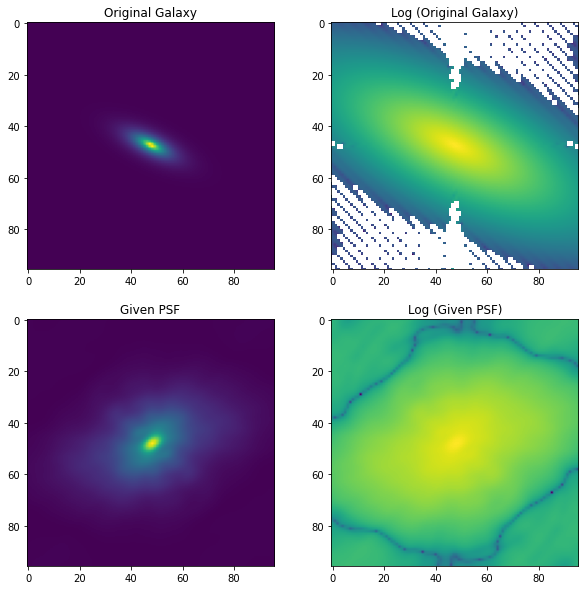

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal); ax1.set_title('Original Galaxy');
ax2.imshow(np.log10(gal)); ax2.set_title('Log (Original Galaxy)');
ax3.imshow(psf); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf)); ax4.set_title('Log (Given PSF)');

### FFT

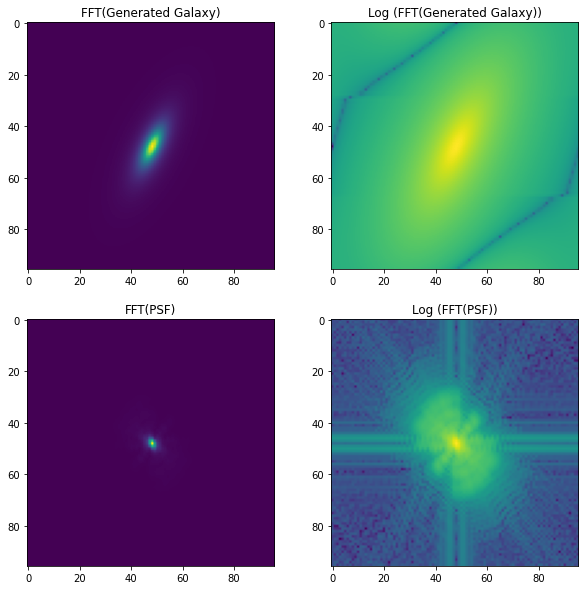

In [7]:
gal_fft = fft.fftshift(fft.fft2(gal))   
psf_fft = fft.fftshift(fft.fft2(psf))      

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(np.abs(gal_fft)); ax1.set_title('FFT(Generated Galaxy)');
ax2.imshow(np.log10(np.abs(gal_fft))); ax2.set_title('Log (FFT(Generated Galaxy))');
ax3.imshow(np.abs(psf_fft)); ax3.set_title('FFT(PSF)');
ax4.imshow(np.log10(np.abs(psf_fft))); ax4.set_title('Log (FFT(PSF))');

### Add Gaussian Noise to FFT(Galaxy)

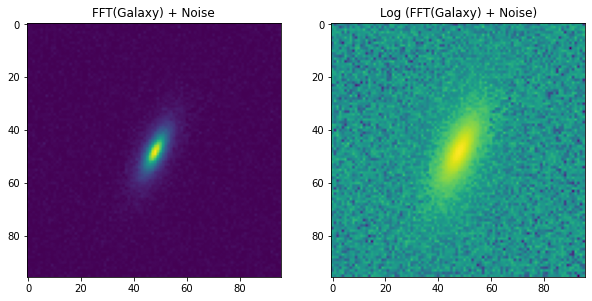

In [8]:
gal_fft_GSO = galsim.Image(gal_fft, copy=True)                  # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma=1e-3)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(np.abs(gal_fft_GSO.array)); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(np.abs(gal_fft_GSO.array))); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

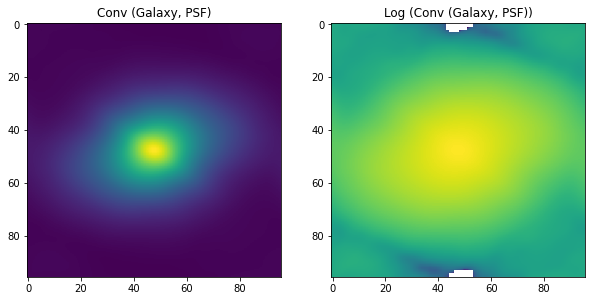

In [9]:
conv = np.multiply(gal_fft_GSO.array, psf_fft)

final_gal = np.real(fft.fftshift(fft.ifft2(fft.ifftshift(conv))))  # IFFT to get back to brightness domain
#final_gal /= np.sum(final_gal)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

# ADMM

In [10]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def l1_norm(signal):

    return np.sum(np.abs(signal))


def sigma_mad(signal):

    return 1.4826 * np.median(np.abs(signal - np.median(signal)))


def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))


def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold /
                     np.maximum(np.finfo(np.float64).eps,
                                np.abs(data))), 0.0) * data,
                     decimals=15)


def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [11]:
# Projection - Enforce non-negative values
def proj(xi):
    
    xi = np.maximum(xi,0)
    return xi


def grad_desc(x_rec, alpha, observation, psf, ST_lambda):
    
    xk = x_rec - alpha*grad(observation, x_rec, psf)
    x_rec = soft_thresh(xk, ST_lambda)
    return x_rec
   
    
def FISTA(tk, xk, x_rec, alpha, observation, psf, ST_lambda):
    
    x_k1 = xk
    x_temp = x_rec - alpha*grad(observation, x_rec, psf)
    x_temp = soft_thresh(x_temp, ST_lambda)
    xk = proj(x_temp)
    t_k1 = (1 + np.sqrt(1 + 4*tk**2))/2
    x_rec = xk + (tk - 1)/t_k1*(xk - x_k1)
    tk = t_k1
    return x_rec, tk, xk


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))


# The gradient
def grad(y, x_rec, psf):

    return ifft(Ht(H(fft(x_rec), psf) - y, psf))


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, reg_lambda, var=1.0):

    cost_val = 0.5*rho*np.linalg.norm(z-x_rec)**2 - np.dot(mu,(z-x_rec)) + (0.5/var)*np.linalg.norm(y - H(fft(x_rec), psf))**2
        
    # For FISTA: cost_val =  (0.5 * np.linalg.norm(y - H(fft(x_rec), psf))**2 + reg_lambda*np.linalg.norm(x_rec))
    
    return cost_val




def runADMM(observation, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, delta_0,
            reg_lambda, ST_lambda, n_iter, alpha=1.0):
    
    cost = []
    nmse_arr = np.zeros(n_iter)
    
    # FISTA parameters
    tk = 1
    xk = first_guess
    
    # ADMM parameters
    x_k = first_guess
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0
    rho_k1 = rho_k
    delta_k = delta_0
        
        
    for k in range(n_iter):
        
        # FISTA update
        x_rec, tk, xk = FISTA(tk, xk, x_k, alpha, observation, psf, ST_lambda)
        
        # Denoising -- CHECK 
        z_k1 = x_rec + (mu_k/rho_k)      # Denoising should be implemented on z_k1 acc. to paper
        
        # mu update -- CHECK (Florent's version has the rho term - The paper does not)
        mu_k1 = mu_k + (x_rec - z_k1)*rho_k
    
        
        # Cost
        cost.append(cost_func(observation, x_rec, z_k1, mu_k1, rho_k1, psf, reg_lambda))
        
        
        # Rho update -- CHECK (1/96) term - taken from Florent's ADMM
        delta_k1 = (1./96.)*(np.linalg.norm(x_rec - x_k) + np.linalg.norm(z_k1 - z_k) + np.linalg.norm(mu_k1 - mu_k))
        
        if (delta_k1 >= eta * delta_k) and (rho_k1 < rho_max):
            rho_k1 = gamma * rho_k
        else:
            rho_k1 = rho_k  
        
        
        x_k = x_rec
        mu_k = mu_k1
        z_k = z_k1
        rho_k = rho_k1
                
        
        
        # Convert back to signal domain
        final_im = np.abs(fft(x_rec))
        nmse_arr[k] = nmse(gal, final_im)
        
        if k%100==0 and k!=0:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
            ax1.imshow(final_im); ax1.set_title('Reconstruction after {} iterations'.format(k));
            ax2.imshow(np.log10(final_im)); ax2.set_title('Log Intensity Scale');
         
            ax3.plot(final_im[48,:], label='rec_im');
            ax3.plot(gal[48,:], label='gal'); 
            leg = ax3.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
            
            display.display(fig)
            display.clear_output(wait=True)
    
    return final_im, nmse_arr, cost

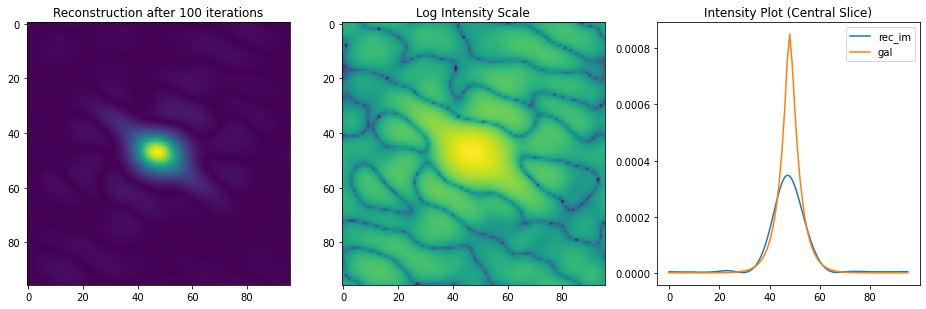

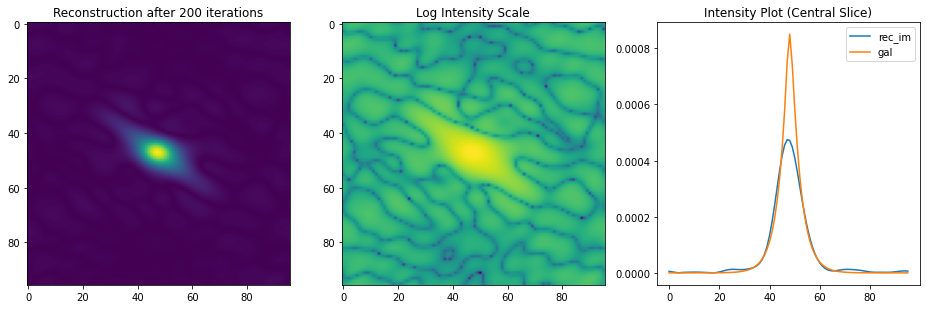

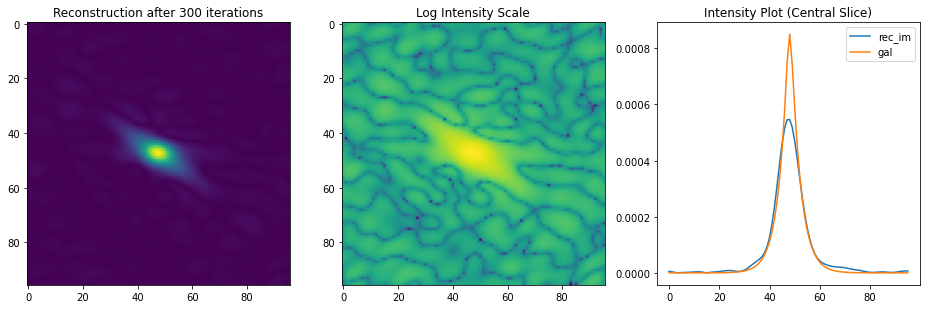

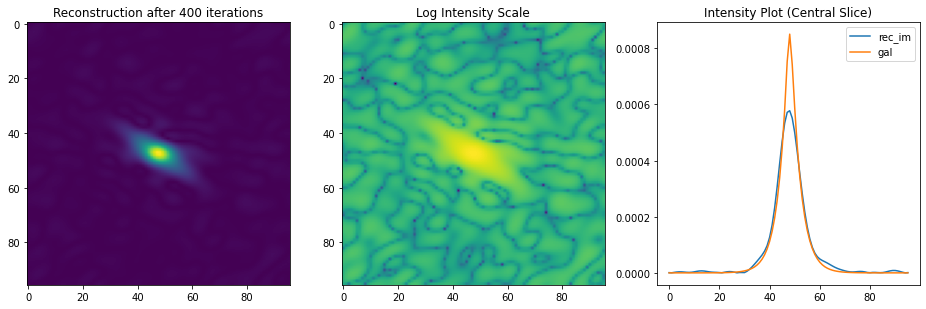

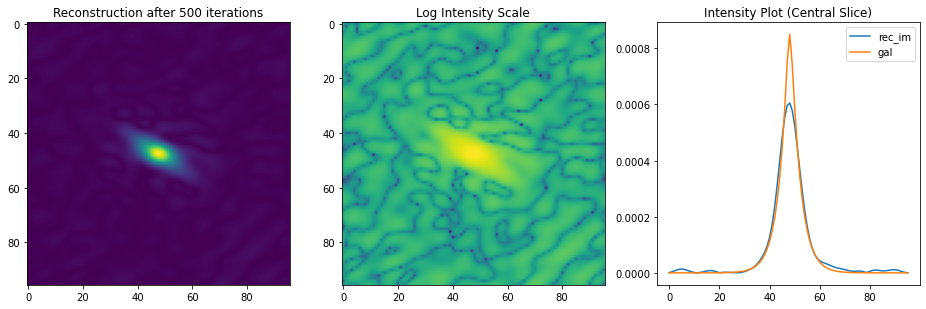

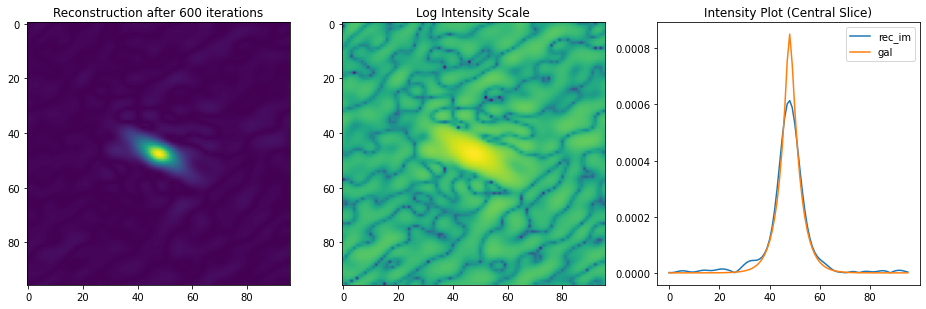

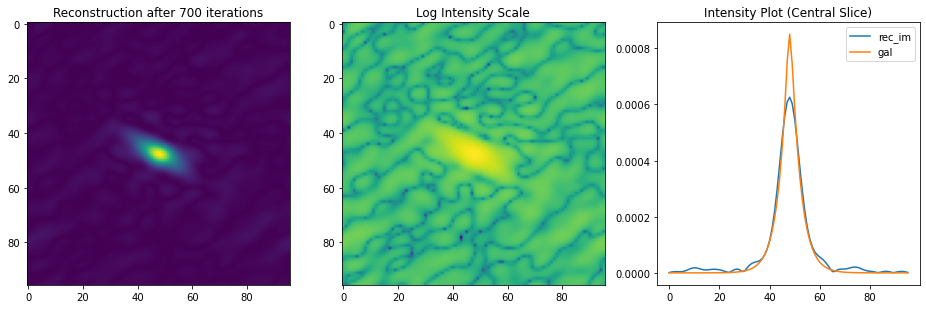

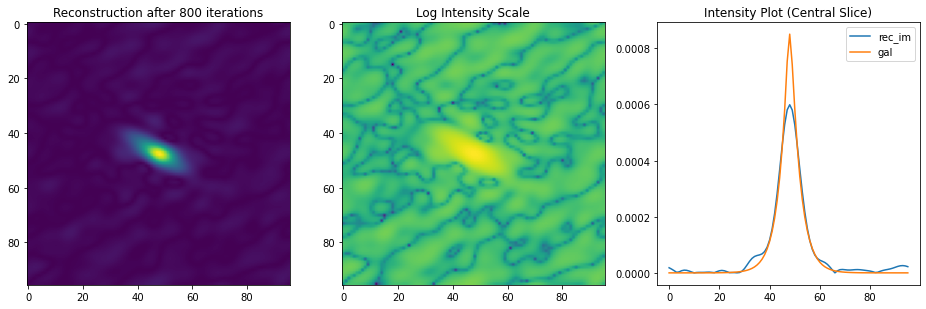

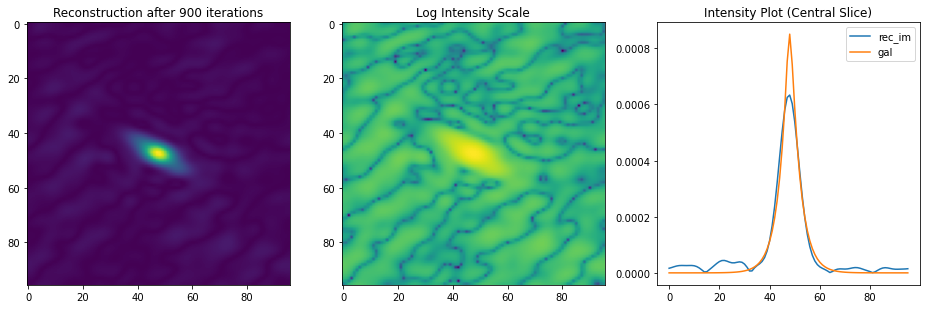

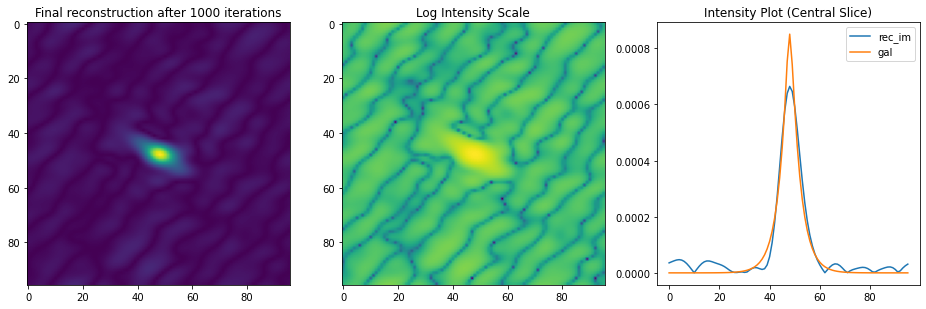

In [12]:
n_iter = 1000

# ADMM parameters
z_0 = 0
mu_0 = 0
rho_0 = 50
rho_max = 200   
eta = 0.5           # Should be between - [0, 1)
gamma = 1.4         # Should be > 1
delta_0 = 0

# Deconvolve the image
final_im, nmse_arr, cost = runADMM(final_gal, np.zeros(final_gal.shape), psf, grad, z_0, mu_0, rho_0, rho_max, 
                                   eta, gamma, delta_0, reg_lambda=1e-4, ST_lambda=1e-10, n_iter=n_iter)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,16))
ax1.imshow(final_im); ax1.set_title('Final reconstruction after {} iterations'.format(n_iter));
ax2.imshow(np.log10(final_im)); ax2.set_title('Log Intensity Scale');

ax3.plot(final_im[48,:], label='rec_im');
ax3.plot(gal[48,:], label='gal'); 
leg = ax3.legend()
ax3.set_aspect(1.0/ax3.get_data_ratio()); ax3.set_title('Intensity Plot (Central Slice)')
plt.show(fig)

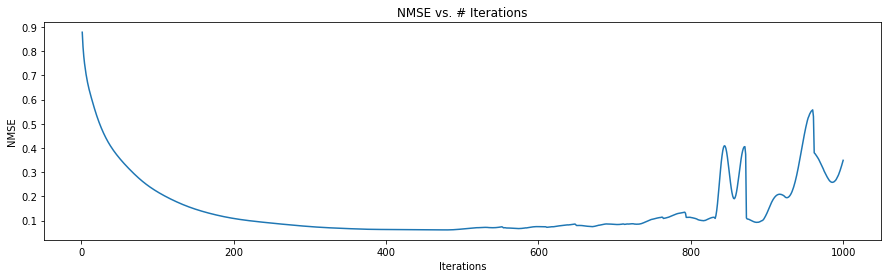


Minimum NMSE at 466 iterations


In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(15,4))
ax1.plot(np.arange(1,n_iter+1), nmse_arr); ax1.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show()

min_iter = np.where(nmse_arr == np.min(nmse_arr[2:]))[0][0]
print('\nMinimum NMSE at {} iterations'.format(min_iter))